In [1]:
%pip install -q -U pip
%pip install -q -U networkx
%pip install -q -U matplotlib
%pip install -q -U numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import collections
import numpy as np

from custommodels.Pickle import pickle

In [3]:
#import data from file
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph(), nodetype=int)
len(G.nodes()), len(G.edges())

(58228, 214078)

# Get largest component

In [4]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [5]:
print("Number of edges:", len(nx.edges(G)))
print("Number of nodes", len(nx.nodes(G)))
print("The average clustering coefficient for the network:", nx.average_clustering(G))
#print("The clustering coefficient for nodes", nx.clustering(G))
print("The maximum degree of the network:", max(dict(G.degree()).values()))

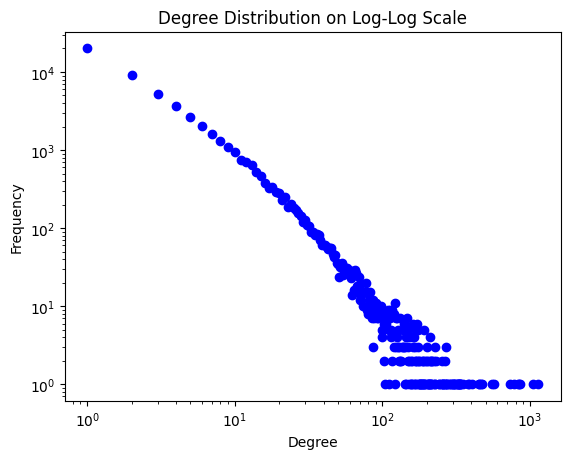

In [6]:
# Calculate the degrees of all nodes and store them in a list
degrees = [degree for node, degree in G.degree()]

# Count the frequency of each degree value
degree_count = Counter(degrees)
degree, frequency = zip(*degree_count.items())

# Create a scatter plot of degrees (log-log scale)
plt.scatter(degree, frequency, c='blue')

# Set the x and y axis to log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution on Log-Log Scale')

# Show the plot
plt.show()

Power law


In [7]:
%pip install -q -U powerlaw

Note: you may need to restart the kernel to use updated packages.


Calculating best minimal value for power law fit


<Axes: >

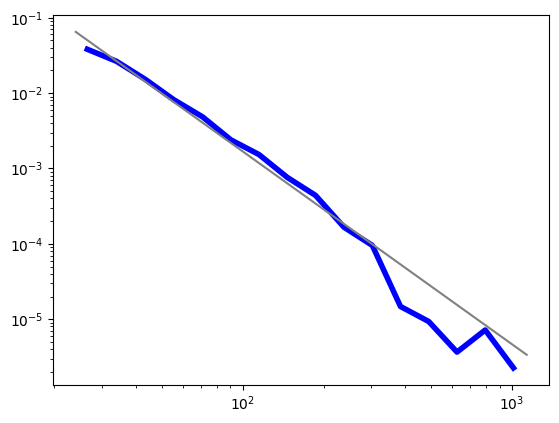

In [8]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
fit = powerlaw.Fit(degree_sequence) 
fig2 = fit.plot_pdf(color='b', linewidth=4)
fit.power_law.plot_pdf(color = "grey", ax=fig2)

CCDF log log scale


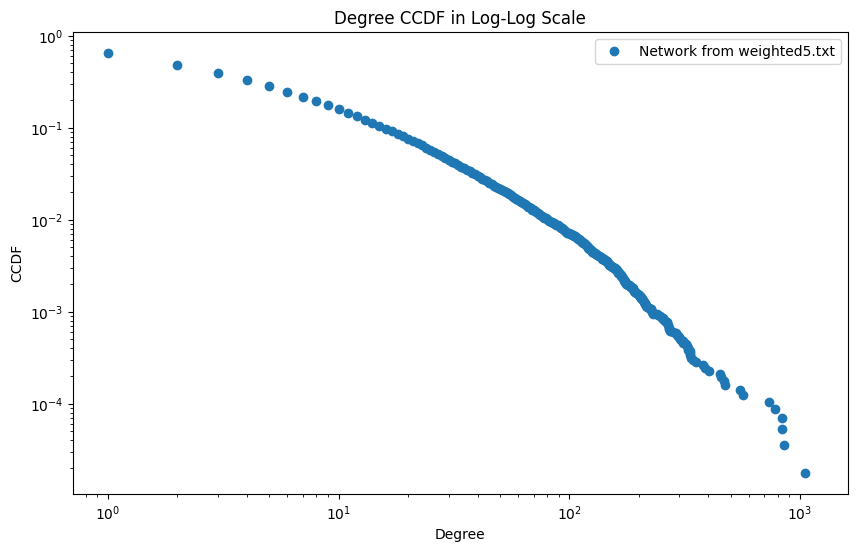

In [9]:
# finding the degree CCDF 
def degree_ccdf(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    degree, count = zip(*degree_count.items())
    ccdf = 1 - np.cumsum(count[::-1])[::-1]/graph.number_of_nodes()
    return degree, ccdf

# plotting the ccdf for the true graph and the random graph 
degree_G, ccdf_G  = degree_ccdf(G)
plt.figure(figsize=(10, 6))
plt.loglog(degree_G, ccdf_G, marker='o', linestyle='None', label='Network from weighted5.txt')
plt.title('Degree CCDF in Log-Log Scale')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.legend()
plt.show()

Density

In [10]:
density = nx.density(G)
density

0.00013229448579703528

Local clustering coefficient

In [11]:
def clusters():
    clusters = nx.clustering(G)
    return clusters

clusters = pickle(clusters)
print(clusters)

Found data, loading from picklejar
{0: 0.0938375350140056, 1: 0.3282051282051282, 2: 0.09903026741110785, 3: 0.028074586214121098, 4: 0.4301994301994302, 5: 0.24514338575393155, 6: 0.05191146881287726, 7: 0.06102145433833302, 8: 0.6666666666666666, 9: 0.3439153439153439, 10: 0.08235294117647059, 11: 0.1358756016290263, 12: 0.06637168141592921, 13: 0.06997762863534676, 14: 0.17142857142857143, 15: 0.13048780487804879, 16: 0.09206349206349207, 17: 0.08436532507739938, 18: 0.1540447504302926, 19: 0.09619450317124736, 20: 0.09102475133009484, 21: 0.07890070921985816, 22: 0.4642857142857143, 23: 0.2206896551724138, 24: 0.16009852216748768, 25: 0.1282051282051282, 26: 0.12468354430379747, 27: 0.04247806937720671, 28: 0.25757575757575757, 29: 0.06231003039513678, 30: 0.039307833556378576, 31: 0.15384615384615385, 32: 0.2222222222222222, 33: 1.0, 34: 0.10795454545454546, 35: 0.030915991949343358, 36: 0.010655675491946369, 37: 0.10599217103282144, 38: 0.3862433862433862, 39: 0.5, 40: 0.01020530

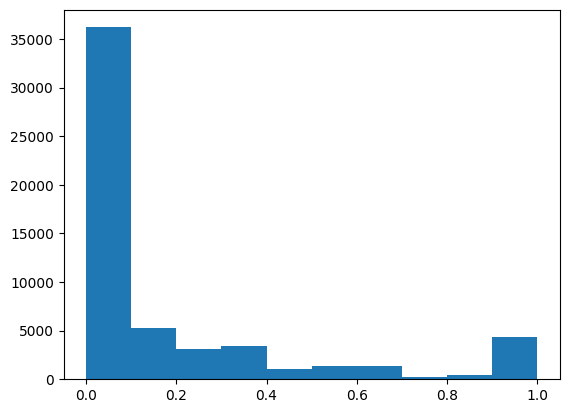

In [12]:
min(clusters.values()) , max(clusters.values())
# (0,1.0) 
plt.hist(clusters.values())
plt.show()
# most nodes have lower clustering coefficients but some also have very high clustering coefficient 

Diameter

In [14]:
def diameter():
    diameter = nx.diameter(G)
    return diameter

diameter = pickle(diameter)
# answer = 18 
print(diameter)

Found data, loading from picklejar
18


Average shortest path

In [15]:
def avg_shortest_path():
    avg_shortest_path = nx.average_shortest_path_length(G)
    return avg_shortest_path
avg_shortest_path = pickle(avg_shortest_path)
avg_shortest_path

# answer: 4.917269741932054

Found data, loading from picklejar


4.917269741932054

Shortest path distribution 

In [21]:
# Can't run it, I don't have enough memory - Ania


def shortest_path_lengths():
    # Calculate shortest path lengths
    all_shortest_path_lengths = {}

    for node in G.nodes:
        shortest_path_lengths = nx.single_source_shortest_path_length(G, node)
        all_shortest_path_lengths[node] = shortest_path_lengths
    return all_shortest_path_lengths

# Calculate shortest paths lengths for our grapgh and store in a pickle
shortest_path_lengths = pickle(shortest_path_lengths)
print(shortest_path_lengths)

No data found, creating new data


KeyboardInterrupt: 

Betweenness centrality

In [ ]:
def betweenness_centrality():
    betweenness_centrality = nx.betweenness_centrality(G)
    return betweenness_centrality
betweenness_centrality = pickle(betweenness_centrality)
betweenness_centrality

Found data, loading from picklejar


{0: 0.0027782250041033085,
 1: 0.00018982797729129089,
 2: 0.0010528766008397162,
 3: 0.009235643798616003,
 4: 0.00014808490951451444,
 5: 0.0004103949944709264,
 6: 0.001906570465119014,
 7: 0.006351480171032358,
 8: 1.0283058986462158e-08,
 9: 0.0002638530413067625,
 10: 0.0007663831030129757,
 11: 0.0009388170519984818,
 12: 0.001290578792613001,
 13: 0.0027401762970616556,
 14: 0.00018472200709877134,
 15: 0.0003178769520871339,
 16: 0.0004148526654272732,
 17: 0.0015359132705463293,
 18: 0.0005376652489143878,
 19: 0.000529870469721093,
 20: 0.0016452755460756858,
 21: 0.0006593984815771676,
 22: 6.928741987384659e-06,
 23: 0.000507492141230547,
 24: 0.0002742208485131949,
 25: 9.903199785339078e-05,
 26: 0.00139962411860137,
 27: 0.005417968494267295,
 28: 0.0002420307629841739,
 29: 0.0029506348828516327,
 30: 0.007011375808041959,
 31: 0.00019186631464922617,
 32: 4.167052190931295e-05,
 33: 0.0,
 34: 0.00034040194583562927,
 35: 0.02498508521877784,
 36: 0.040196157255756634,

Degree distribution dictionary

In [23]:



try:
    sorted_degree = load("sorted_degree.pkl")
except:
    degree_dict = dict(G.degree)
    sorted_degree = (sorted(degree_dict.items(), key=lambda item: item[1], reverse = True))
    sorted_degree
    save("sorted_degree.pkl", sorted_degree)


Failed to load data.
